## All of the Imports 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from PIL import Image
import cv2
%matplotlib inline 

import os
from random import shuffle 

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,roc_curve,roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder

from keras.preprocessing.image import ImageDataGenerator

from tensorflow import keras
from tensorflow.keras import layers

from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from keras.utils import to_categorical

from keras.layers import Dropout, Flatten,Activation
from keras.models import Model
from keras.applications import VGG16,VGG19
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization

import tensorflow as tf
import random 

import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')


Using TensorFlow backend.


## Data loading ..

In [2]:
directory = "/Users/n94wd/OneDrive/Desktop/Datasets/flower/flowers/flowers"

In [3]:
classes = os.listdir(directory)
classes

['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']

In [4]:
def load_data(direct):
    data = []
    for i in classes:
        path = os.path.join(direct,i)
        classes_num = classes.index(i)
        for j in os.listdir(path):
            if j.endswith('.jpg'):
                img = cv2.imread(os.path.join(path,j),cv2.IMREAD_COLOR)
                img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
                img = cv2.resize(img,(224,224))
                data.append([img,classes_num])
    return np.array(data)

In [5]:
dataset = load_data(directory)
x = []
y = []

for f, l in dataset:
    x.append(f)
    y.append(l)

In [6]:
# Normalize the data
x = np.array(x) / 255
# Reshaping the data from 1-D to 3-D as required through input by CNN's 
x = x.reshape(-1, 224, 224, 3)
y = np.array(y)

## Data visualization...

<AxesSubplot:xlabel='Types of Flowers', ylabel='count'>

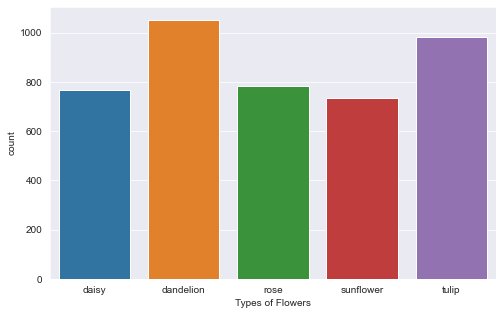

In [7]:

def count_plot(src):
    cplot = []
    for i in src:
          cplot.append(classes[i[1]])
    sns.set_style('darkgrid')
    plt.figure(figsize=(8,5))
    plt.xlabel('Types of Flowers')
    fig = sns.countplot(cplot)
    return fig
    
count_plot(dataset)

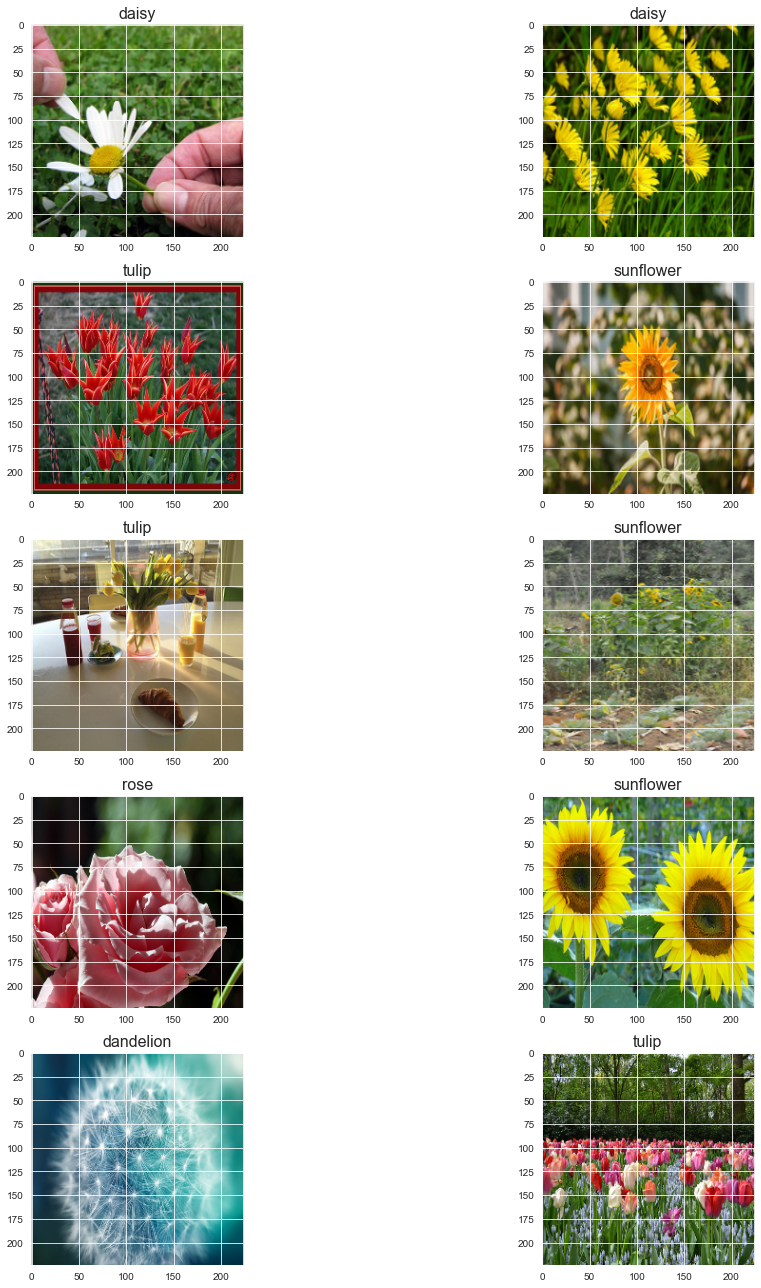

In [8]:
def visualize_images(dataset):
    fig,ax=plt.subplots(5,2)
    fig.set_size_inches(18,18)
    for i in range(5):
        for j in range (2):
            l=random.randint(0,len(dataset))
            ax[i,j].imshow(dataset[l][0])
            ax[i,j].set_title(classes[dataset[l][1]],fontsize=16)
        
    plt.tight_layout()

visualize_images(dataset)

## VGG16
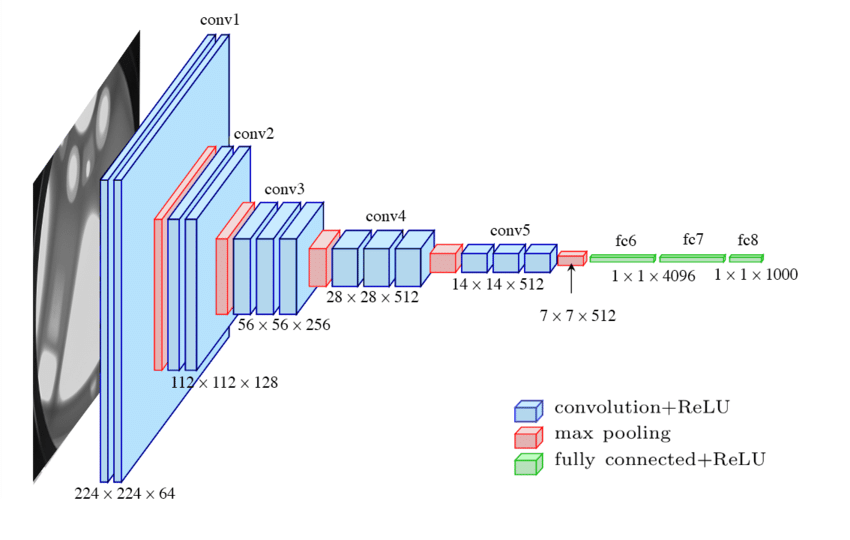
A fixed size of (224 * 224) RGB image was given as input to this network which means that the matrix was of shape (224,224,3).

The only preprocessing that was done is that they subtracted the mean RGB value from each pixel, computed over the whole training set.

Used kernels of (3 * 3) size with a stride size of 1 pixel, this enabled them to cover the whole notion of the image.
spatial padding was used to preserve the spatial resolution of the image.

max pooling was performed over a 2 * 2 pixel windows with sride 2.

this was followed by Rectified linear unit(ReLu) to introduce non-linearity to make the model classify better and to improve computational time as the previous models used tanh or sigmoid functions this proved much better than those.

implemented three fully connected layers from which first two were of size 4096 and after that a layer with 1000 channels for 1000-way ILSVRC classification and the final layer is a softmax function.

In [9]:
from tensorflow.keras.utils import to_categorical
y=to_categorical(y)
y.shape

(4323, 5)

In [10]:
x.shape

(4323, 224, 224, 3)

In [11]:
x_train,x_test,y_train,y_test = train_test_split(x , y , test_size = 0.25 ,  random_state = 0)

## Data Augmentation- a technique used to reduce overfittting 

In [12]:
def aug_data():
    dataaug= ImageDataGenerator(horizontal_flip=True,
                                width_shift_range=0.2,
                                height_shift_range=0.2,
                                vertical_flip= True,
                                rotation_range=10,
                                zoom_range= 0.1)
    return dataaug
    

In [13]:
datagen = aug_data()
datagen.fit(x_train)


## Modeling

In [14]:
def vgg_model():
    vgg = VGG16(input_shape=(224,224,3), include_top=False, weights="imagenet")
    
    for layer in vgg.layers:
        layer.trainable = False
    
    p = Flatten()(vgg.output)
    p = Dense(500, activation='relu', name='fc1')(p)
    p = Dropout(0.4)(p)
    p = Dense(5, activation='softmax', name='fc2')(p)
    
    
    model = Model(inputs=vgg.input, outputs=p)
    
    return model

In [15]:
model = vgg_model()

model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [16]:
from keras.callbacks import ReduceLROnPlateau
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.00001)

In [17]:
history=model.fit(x_train,y_train,epochs=10,validation_data=(x_test,y_test),batch_size=32,callbacks = [learning_rate_reduction])

Train on 3242 samples, validate on 1081 samples
Epoch 1/10
3242/3242 [==============================] - 118s 36ms/step - loss: 1.3396 - accuracy: 0.5028 - val_loss: 0.9448 - val_accuracy: 0.5606
Epoch 2/10
3242/3242 [==============================] - 65s 20ms/step - loss: 0.9051 - accuracy: 0.6391 - val_loss: 0.8336 - val_accuracy: 0.6957
Epoch 3/10
3242/3242 [==============================] - 62s 19ms/step - loss: 0.7372 - accuracy: 0.7224 - val_loss: 0.7701 - val_accuracy: 0.6929
Epoch 4/10
3242/3242 [==============================] - 71s 22ms/step - loss: 0.5938 - accuracy: 0.7841 - val_loss: 0.7339 - val_accuracy: 0.7327
Epoch 5/10
3242/3242 [==============================] - 117s 36ms/step - loss: 0.4693 - accuracy: 0.8242 - val_loss: 0.6582 - val_accuracy: 0.7872
Epoch 6/10
3242/3242 [==============================] - 98s 30ms/step - loss: 0.4634 - accuracy: 0.8319 - val_loss: 0.7881 - val_accuracy: 0.7604
Epoch 7/10
3242/3242 [==============================] - 278s 86ms/step - l

## Accuracy and loss of the model

In [18]:
print("Accuracy of the model: ",  model.evaluate(x_test,y_test)[1]*100 , "%")

print("Loss of the model: ", model.evaluate(x_test,y_test)[0])

1081/1081 [==============================] - 25s 23ms/step
Accuracy of the model:  82.5161874294281 %
1081/1081 [==============================] - 24s 22ms/step
Loss of the model:  0.6604111001488239


## Visualization of accuracy and loss ....

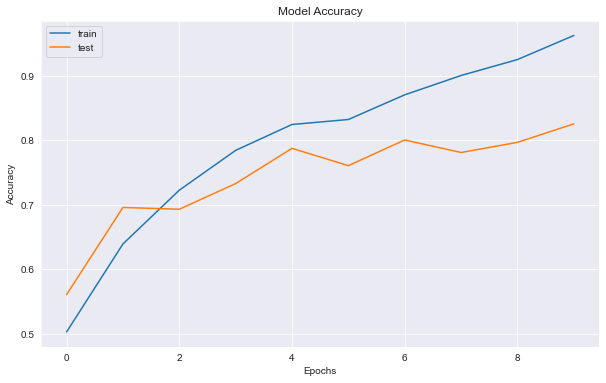

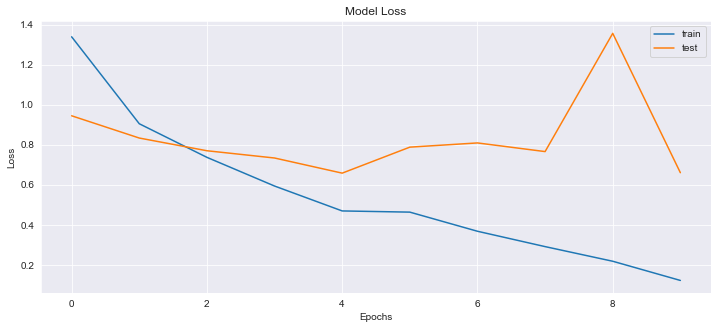

In [19]:
sns.set_style('darkgrid')
plt.figure(figsize=(10,6))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

sns.set_style('darkgrid')
plt.figure(figsize=(12,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

## predictions

In [30]:
model.evaluate(x_test,y_test)

1081/1081 [==============================] - 8s 8ms/step


[0.6604111001488239, 0.825161874294281]

In [34]:
preds=model.predict(x_test)
predictions=np.argmax(preds,axis=1)

In [39]:
predictions[:16]

array([2, 2, 4, 1, 3, 4, 3, 3, 4, 0, 1, 4, 3, 2, 4, 2], dtype=int64)